# Transistor BFP640

Se importan las librerias necesarias para trabajar posteriormente.

In [4]:
!pip3 install scikit-rf

In [104]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

In [5]:
path = '/Users/federicovillar/Documents/GitHub/laboratorios_EA3/TP2/bfp_transistor/SPAR/BFP640/BFP640_VCE_'

## Ploteo de parámetros S

Por ejemplo, para una polarización con:
- $V_{CE}=1 \ V$
- $I_C=18 \ mA$

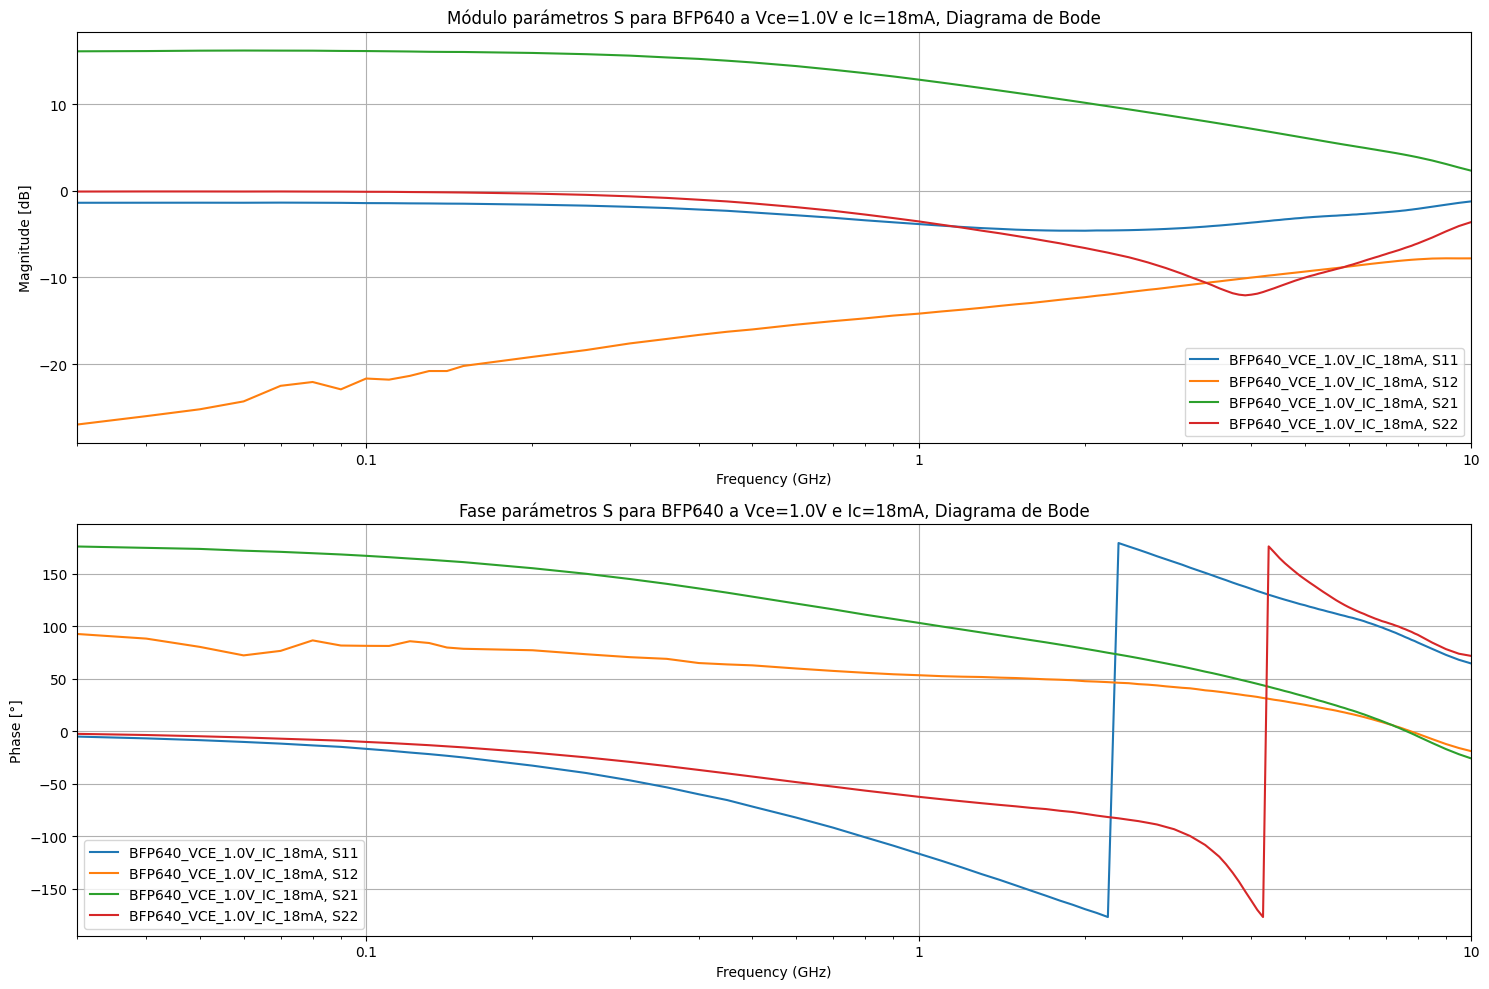

In [6]:
bfp640_1 = rf.Network(path+'1.0V_IC_18mA.s2p')
fig, ax = plt.subplots(2, 1, figsize=(15,10))

ax[0].grid(True)
ax[0].set_title('Módulo parámetros S para BFP640 a Vce=1.0V e Ic=18mA, Diagrama de Bode')
ax[0].set_ylabel('Magnitude [dB]')
ax[0].set_xlabel('Frecuencia [GHz]')
bfp640_1.plot_s_db10(ax=ax[0],  logx=True)

ax[1].grid(True)
ax[1].set_title('Fase parámetros S para BFP640 a Vce=1.0V e Ic=18mA, Diagrama de Bode')
ax[1].set_ylabel('Phase [°]')
ax[1].set_xlabel('Frecuencia [GHz]')
bfp640_1.plot_s_deg(ax=ax[1], logx=True)

plt.tight_layout()
plt.savefig('vce_10_ic_18.pdf')

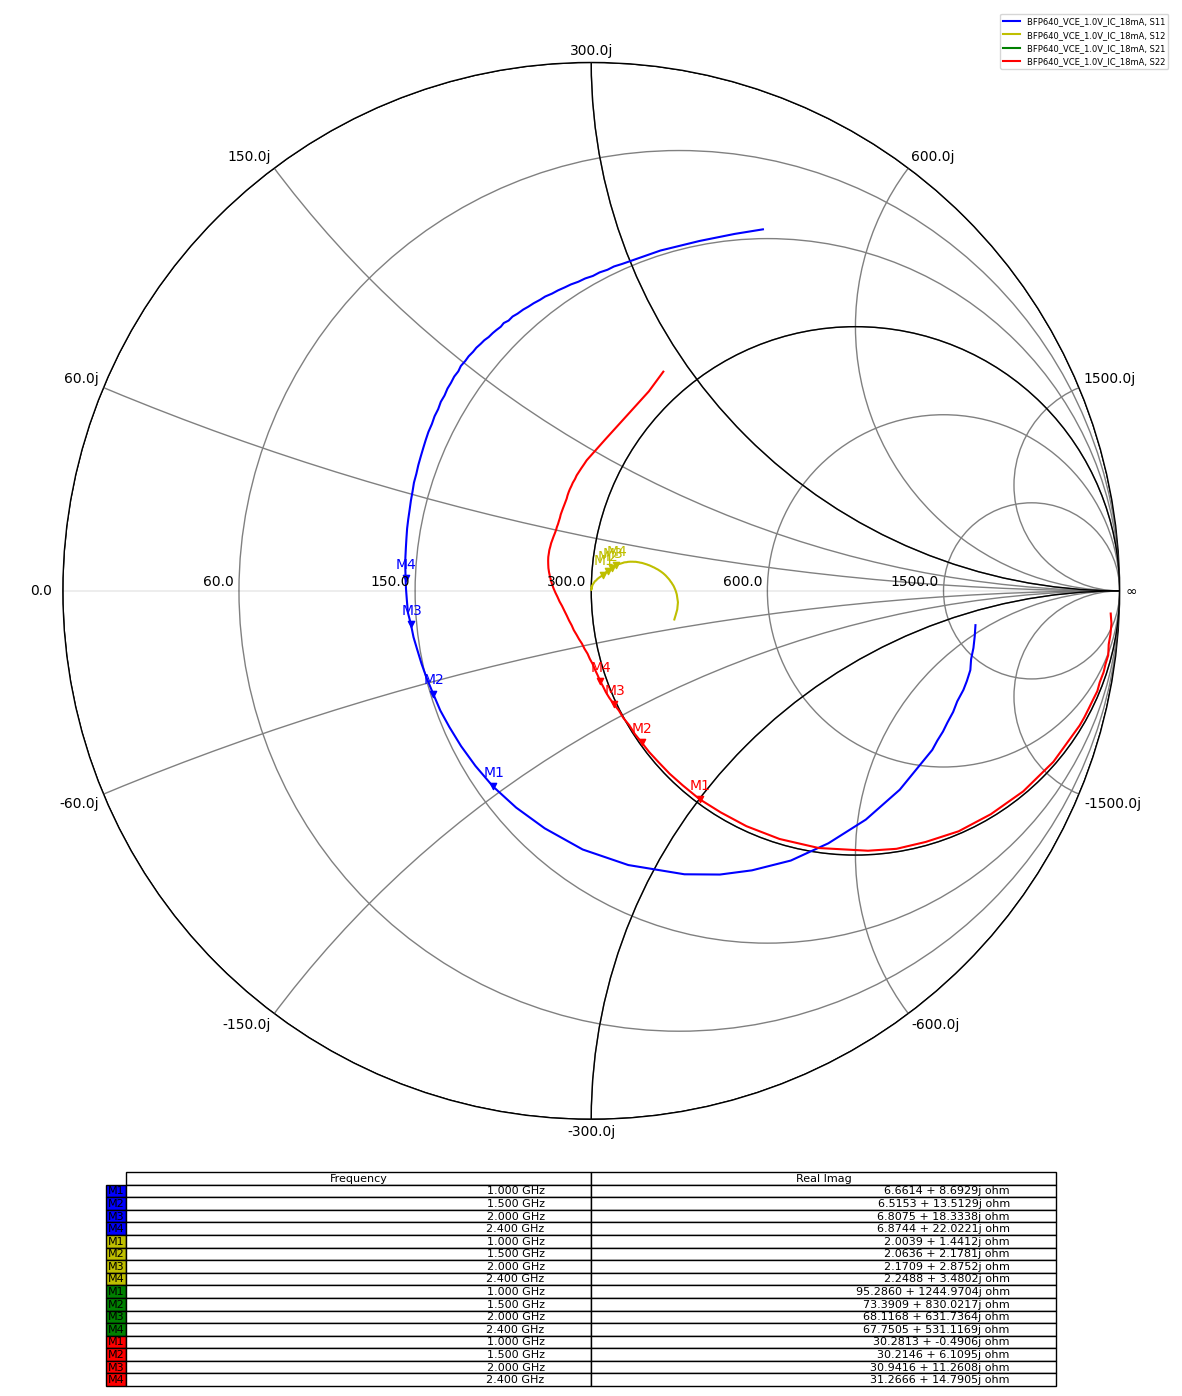

In [7]:
size = bfp640_1.s.real.shape[0]

lines = [
    {'marker_idx': [24,29,34,38], 'color': 'b', 'm': 0, 'n': 0, 'ntw': bfp640_1},
    {'marker_idx': [24,29,34,38], 'color': 'y', 'm': 0, 'n': 1, 'ntw': bfp640_1},
    {'marker_idx': [24,29,34,38], 'color': 'g', 'm': 1, 'n': 0, 'ntw': bfp640_1},
    {'marker_idx': [24,29,34,38], 'color': 'r', 'm': 1, 'n': 1, 'ntw': bfp640_1},
]

fig, ax = plt.subplots(1, 1, figsize=(15,20))

rf.plotting.smith(ax = ax, draw_labels = True, ref_imm = 300, chart_type = 'z')

col_labels = ['Frequency', 'Real Imag']
row_labels = []
row_colors = []
cell_text = []
for l in lines:
    m = l['m']
    n = l['n']
    l['ntw'].plot_s_smith(m=m, n=n, ax = ax, color=l['color'])
    #plot markers
    for i, k in enumerate(l['marker_idx']):
        x = l['ntw'].s.real[k, m, n]
        y = l['ntw'].s.imag[k, m, n]
        z = l['ntw'].z[k, m, n]
        z = f'{z.real:.4f} + {z.imag:.4f}j ohm'
        f = l['ntw'].frequency.f_scaled[k]
        f_unit = l['ntw'].frequency.unit
        row_labels.append(f'M{i + 1}')
        row_colors.append(l['color'])
        ax.scatter(x, y, marker = 'v', s=20, color=l['color'])
        ax.annotate(row_labels[-1], (x, y), xytext=(-7, 7), textcoords='offset points', color=l['color'])
        cell_text.append([f'{f:.3f} {f_unit}', z])
leg1 = ax.legend(loc="upper right", fontsize= 6)

the_table = ax.table(cellText=cell_text,
                      colWidths=[0.4] * 2,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      rowColours=row_colors,
                      loc='bottom')
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
#the_table.scale(1.5, 1.5)
plt.savefig('vce_10_ic_18_smith.pdf')

## Ejemplo de diseño

In [9]:
S_11 = 0.656*np.exp(1j*np.deg2rad(146.7))
S_12 = 0.122*np.exp(1j*np.deg2rad(46.1))
S_21 = 2.3*np.exp(1j*np.deg2rad(44.7))
S_22 = 0.172*np.exp(1j*np.deg2rad(-117.1))

In [73]:
def calc_Imp(S_11, S_12, S_21, S_22, Zo):
    # Se definen los módulos
    Smod11=np.abs(S_11)
    Smod12=np.abs(S_12)
    Smod21=np.abs(S_21)
    Smod22=np.abs(S_22)

    # Se obtiene el valor de delta
    delta=S_11*S_22-S_12*S_21

    # Se analiza estabilidad
    K=np.inf if Smod12*Smod21 == 0 else (1-Smod11**2-Smod22**2+np.abs(delta)**2)/(2*Smod12*Smod21)
    if K<1:
        return None
    
    # Se obtienen los valores de las variables auxiliares
    B1=1+Smod11**2-Smod22**2-np.abs(delta)**2
    B2=1+Smod22**2-Smod11**2-np.abs(delta)**2
    C1=S_11-(delta*np.conj(S_22))
    C2=S_22-(delta*np.conj(S_11))
    Cmod1=np.abs(C1)
    Cang1=np.angle(C1)
    Cmod2=np.abs(C2)
    Cang2=np.angle(C2)

    # Se calculan las reflexiones de entrada y salida del transistor
    Rmod_in=np.inf if Cmod1 == 0 else (B1-np.sqrt(B1**2-4* Cmod1**2))/(2*Cmod1)
    Rang_in=Cang1
    Rmod_out=np.inf if Cmod2 == 0 else (B2-np.sqrt(B2**2-4* Cmod2**2))/(2*Cmod2)
    Rang_out=Cang2

    Ri=Rmod_in*np.exp(1j*Rang_in)
    Ro=Rmod_out*np.exp(1j*Rang_out)
    
    # Se calculan las impedancias de entrada y salida del transistor
    Zi=Zo*(1+Ri)/(1-Ri)
    Zo=Zo*(1+Ro)/(1-Ro)

    # Se calculan las impedancias de fuente y de carga que deberá ver el transistor
    Zs=np.round(np.conj(Zi),2)
    Zl=np.round(np.conj(Zo),2)
    return Zs,Zl,K

In [21]:
print(calc_Imp(S_11, S_12, S_21, S_22,50))
Zs = calc_Imp(S_11, S_12, S_21, S_22,50)[0]
Zl = calc_Imp(S_11, S_12, S_21, S_22,50)[1]

((4.322388722517881-13.133363628214699j), (25.54722915709502+56.90230816486328j))


- $f=1.8 \ GHz$
- Transistor BFP450

Para poder verificar que es incondicionalmente estable, con los parámetros que tenemos sacamos las diferentes polarizaciones.

In [87]:
in_path = '/Users/federicovillar/Documents/GitHub/laboratorios_EA3/TP2/bfp_transistor/SPAR/BFP450/BFP450_w_noise_VCE_'
vce = ['1.0V','2.0V','2.5V','3.0V','4.0V']
ic = ['5.0mA','10mA','15mA','20mA','25mA','30mA','40mA','50mA','60mA','70mA','80mA','90mA','0.10A','0.11A','0.14A','0.16A','0.18A','0.20A']
df = pd.DataFrame(columns=['Vce','Ic','Zs','Zl','K','S11','S12','S21','S22'])

for v in vce:
    for i in ic:
        try:
            str_model = in_path+v+'_IC_'+i+'.s2p'
            model = rf.Network(str_model)
            S11 = model['1.8ghz'].s[0][0][0]
            S12 = model['1.8ghz'].s[0][0][1]
            S21 = model['1.8ghz'].s[0][1][0]
            S22 = model['1.8ghz'].s[0][1][1]
            results = calc_Imp(S11, S12, S21, S22, 50)
            if results != None:
                values = pd.DataFrame({'Vce':[v],'Ic':[i],'Zs':[results[0]],'Zl':[results[1]],'K':[results[2]],'S11':[np.round(S11,2)],'S12':[np.round(S12,2)],'S21':[np.round(S21,2)],'S22':[np.round(S22,2)]})
                df = pd.concat([df, values], ignore_index=True)
        except:
            pass
def convert_current(value):
    if 'mA' in value:
        return float(value.replace('mA', '')) / 1000
    elif 'A' in value:
        return float(value.replace('A', ''))
    else:
        return float(value)

df['Ic'] = df['Ic'].apply(convert_current)
df['Vce'] = df['Vce'].str.replace('V', '').astype(float)
#df.to_excel('posibles_polarizaciones.xlsx',index=False)

/var/folders/f3/nkkrwm_d743_834rxp66g04w0000gn/T/ipykernel_9459/17058792.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, values], ignore_index=True)


El siguiente dataframe muestra las polarizaciones, el $K$, $Z_L$ y $Z_S$ a implementar para las configuraciones estables.

In [88]:
df

,Vce,Ic,Zs,Zl,K,S11,S12,S21,S22
0,1.0,0.015,0.87-3.70j,2.60+17.49j,1.003622,-0.72+0.25j,0.06+0.04j,1.56+2.51j,-0.49+0.08j
1,1.0,0.020,3.20-4.37j,9.49+15.99j,1.039479,-0.71+0.27j,0.06+0.04j,1.62+2.60j,-0.51+0.11j
2,1.0,0.025,4.21-4.86j,12.42+14.72j,1.058605,-0.71+0.29j,0.05+0.05j,1.66+2.66j,-0.53+0.13j
3,1.0,0.030,4.86-5.30j,14.33+13.71j,1.069135,-0.71+0.30j,0.05+0.05j,1.68+2.70j,-0.54+0.15j
4,1.0,0.040,5.63-5.90j,16.61+12.21j,1.078678,-0.70+0.31j,0.05+0.05j,1.71+2.74j,-0.55+0.17j
...,...,...,...,...,...,...,...,...,...
63,4.0,0.070,6.42-6.47j,24.24+19.24j,1.079665,-0.67+0.30j,0.04+0.05j,2.19+3.65j,-0.47+0.11j
64,4.0,0.080,6.56-6.65j,25.06+18.84j,1.080673,-0.67+0.30j,0.04+0.05j,2.19+3.66j,-0.47+0.11j
65,4.0,0.090,6.66-6.86j,25.77+18.53j,1.081424,-0.67+0.30j,0.04+0.05j,2.19+3.66j,-0.48+0.12j
66,4.0,0.100,6.77-7.06j,26.54+18.15j,1.083299,-0.67+0.31j,0.04+0.05j,2.19+3.66j,-0.48+0.12j


Sin embargo, el fabricante brinda datos en donde la corriente de colector de polarización supera a la máxima que puede soportar el transitor físico, es por eso que se filtra la información.

In [90]:
ic_threshold = 0.17
df_filtered = df[df['Ic'] < ic_threshold]
df_filtered.to_excel('posibles_polarizaciones.xlsx',index=False)
df_filtered

,Vce,Ic,Zs,Zl,K,S11,S12,S21,S22
0,1.0,0.015,0.87-3.70j,2.60+17.49j,1.003622,-0.72+0.25j,0.06+0.04j,1.56+2.51j,-0.49+0.08j
1,1.0,0.020,3.20-4.37j,9.49+15.99j,1.039479,-0.71+0.27j,0.06+0.04j,1.62+2.60j,-0.51+0.11j
2,1.0,0.025,4.21-4.86j,12.42+14.72j,1.058605,-0.71+0.29j,0.05+0.05j,1.66+2.66j,-0.53+0.13j
3,1.0,0.030,4.86-5.30j,14.33+13.71j,1.069135,-0.71+0.30j,0.05+0.05j,1.68+2.70j,-0.54+0.15j
4,1.0,0.040,5.63-5.90j,16.61+12.21j,1.078678,-0.70+0.31j,0.05+0.05j,1.71+2.74j,-0.55+0.17j
...,...,...,...,...,...,...,...,...,...
63,4.0,0.070,6.42-6.47j,24.24+19.24j,1.079665,-0.67+0.30j,0.04+0.05j,2.19+3.65j,-0.47+0.11j
64,4.0,0.080,6.56-6.65j,25.06+18.84j,1.080673,-0.67+0.30j,0.04+0.05j,2.19+3.66j,-0.47+0.11j
65,4.0,0.090,6.66-6.86j,25.77+18.53j,1.081424,-0.67+0.30j,0.04+0.05j,2.19+3.66j,-0.48+0.12j
66,4.0,0.100,6.77-7.06j,26.54+18.15j,1.083299,-0.67+0.31j,0.04+0.05j,2.19+3.66j,-0.48+0.12j


Se muestran diferentes modos de representación de los datos, de modo de poder verificar las zonas en donde se tienen datos más apropiados para el diseño del trabajo práctico.

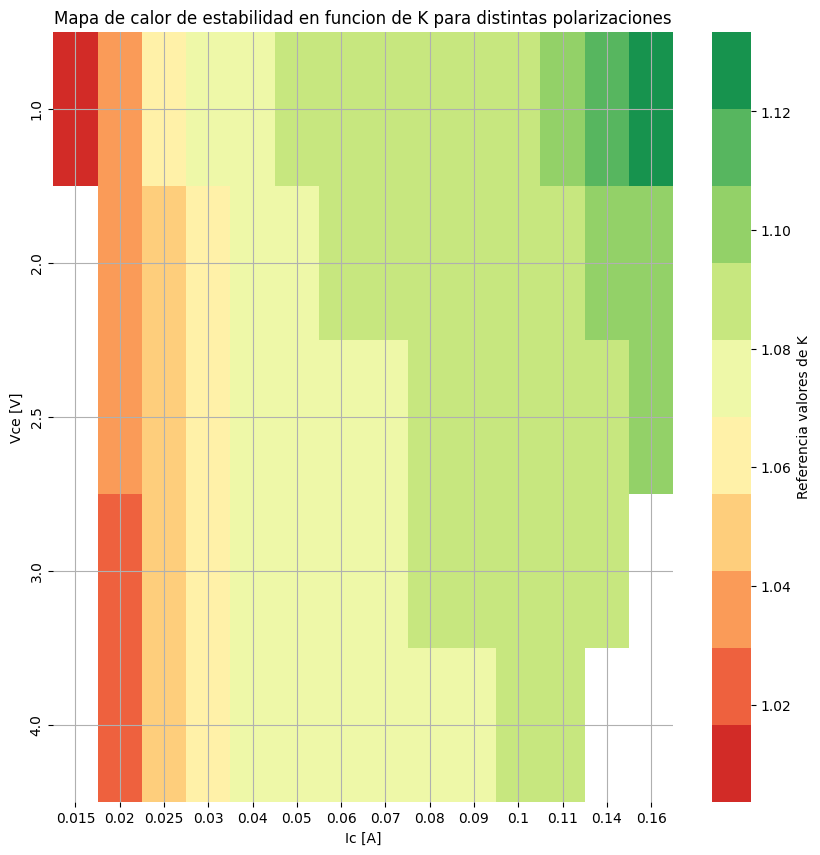

In [102]:
heatmap_data = df_filtered.pivot(index='Vce', columns='Ic', values='K')
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap=sns.color_palette("RdYlGn", 10), cbar_kws={'label': 'Referencia valores de K'})
plt.title('Mapa de calor de estabilidad en funcion de K para distintas polarizaciones')
plt.xlabel('Ic [A]')
plt.ylabel('Vce [V]')
plt.grid(True)

plt.savefig('heatmap.pdf')
plt.savefig('heatmap.png')

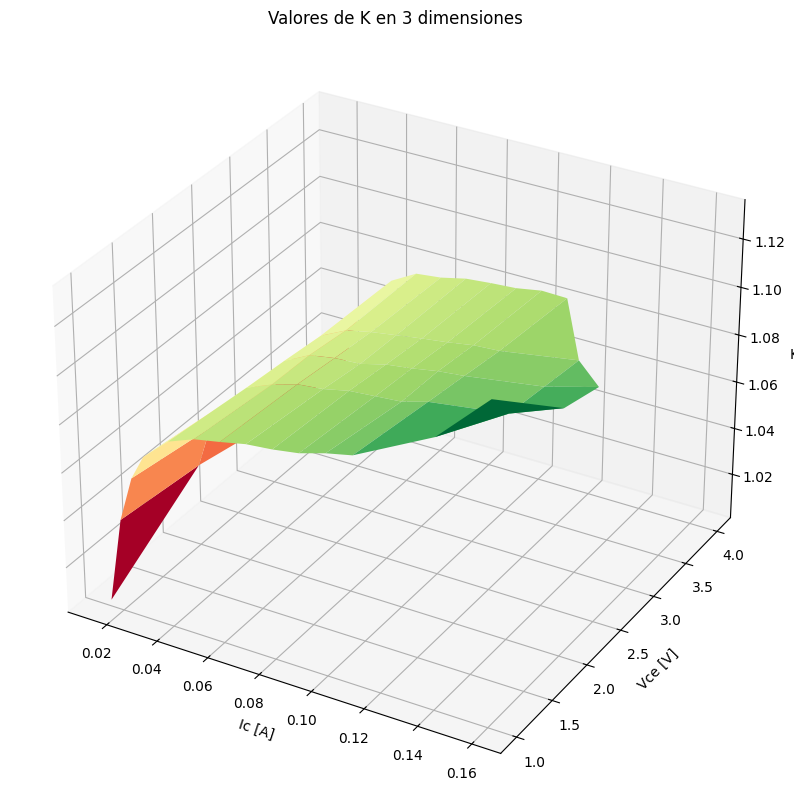

In [107]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
heatmap_data.index = pd.to_numeric(heatmap_data.index)
heatmap_data.columns = pd.to_numeric(heatmap_data.columns)
x = heatmap_data.columns
y = heatmap_data.index
X, Y = np.meshgrid(x, y)
Z = heatmap_data.values

ax.plot_surface(X, Y, Z, cmap='RdYlGn')
ax.set_xlabel('Ic [A]')
ax.set_ylabel('Vce [V]')
ax.set_zlabel('K')
ax.set_title('Valores de K en 3 dimensiones')
ax.grid(True)

plt.savefig('3dplot.pdf')
plt.savefig('3dplot.png')